## Predict Age from Face Image by Pytorch
- dataset: https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from PIL import Image
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from glob import glob

In [3]:
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch import optim, nn
import torchvision.models as models
import torch

In [4]:


class FaceAgeDataset(Dataset):
    def __init__(self, files, transform=None):
        self.all_files = files
        self.transform = transform
        self.pat = re.compile(r"_(\d{4}).+?_(\d{4})")
    def __getitem__(self, index):
        X = Image.open(self.all_files[index])
        if self.transform:
            X = self.transform(X)
        if X.size()[0] == 1:
            X = torch.cat([X, X, X], dim=0)
        birth, taken = self.pat.findall(self.all_files[index])[0]
        y = int(taken) - int(birth)
        y = min(max(0, y), 100) / 100.
        return (X, y)
    def __len__(self):
        return len(self.all_files)

In [5]:
fmatcher = "/home/dola/data/wiki_crop/*/*.jpg"
all_files = glob(fmatcher)
def is_valid_file(f):
    try:
        birth, taken = re.findall(r"_(\d{4}).+?_(\d{4})", f)[0]
        years = int(taken) - int(birth)
        if years < 20 or years > 60:
            return False
    except:
        return False
    return True

all_files = list(filter(is_valid_file, all_files))
train_files, test_files = train_test_split(all_files, test_size=0.15)
len(train_files), len(test_files)

(42830, 7559)

In [6]:


# for pretrained model
preprocess = transforms.Compose([
    transforms.Scale(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data = FaceAgeDataset(train_files, transform=preprocess)
test_data = FaceAgeDataset(test_files, transform=preprocess)

assert train_data[100][0].size() == (3, 224, 224)

len(train_data), len(test_data)

(42830, 7559)

In [10]:
batch_size = 128
train_batches = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, )
test_batches = DataLoader(test_data, batch_size=32, shuffle=True, num_workers=4)

In [11]:
class FaceAgeModel(nn.Module):
    def __init__(self):
        super(FaceAgeModel, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        for p in self.features.parameters():
            p.require_grad = False
        self.linear1 = nn.Linear(512, 1000)
        self.elu = nn.ELU()
        self.linear2 = nn.Linear(1000, 1)
    def forward(self, X):
        f = self.features(X)
#         print(f.size())
        hidden = self.linear1(f.view(f.size()[0], -1))
        hidden = self.elu(hidden)
        age = self.linear2(hidden)
        return age
    
model = FaceAgeModel().cuda()
objective = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=5e-4)

In [12]:
## training
model.train()

n_epochs = 20

for epoch in range(n_epochs):
    for i, (imgs, ages) in enumerate(train_batches):
        X = Variable(imgs).cuda()
        y = Variable(ages).type(torch.FloatTensor).cuda()
        
        yhat = model(X)
        loss = objective(yhat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 200 == 0:
            print(epoch, i, loss.data[0])

0 0 0.09480641782283783
0 200 0.010562385432422161
1 0 0.0072813015431165695
1 200 0.006164454855024815
2 0 0.008850115351378918
2 200 0.0044180117547512054
3 0 0.004006281960755587
3 200 0.0070496778935194016
4 0 0.004474842920899391
4 200 0.006229333579540253
5 0 0.00914057344198227
5 200 0.004308608360588551
6 0 0.006387629546225071
6 200 0.0041831983253359795
7 0 0.0033542723394930363
7 200 0.0026340698823332787
8 0 0.002713727531954646
8 200 0.0029373755678534508
9 0 0.002029338851571083
9 200 0.0040580760687589645
10 0 0.0018093731487169862
10 200 0.003436930011957884
11 0 0.0026003788225352764
11 200 0.002145282458513975
12 0 0.0047018504701554775
12 200 0.0018377829110249877
13 0 0.0022818997967988253
13 200 0.0019647874869406223
14 0 0.00210383883677423
14 200 0.0019028333481401205
15 0 0.004817571956664324
15 200 0.003684544935822487
16 0 0.003245025407522917
16 200 0.002404860220849514
17 0 0.0030023108702152967
17 200 0.0031460425816476345
18 0 0.002981750527396798
18 200 0

In [13]:
torch.save(model.state_dict(), "models/model1.t")

In [14]:
model.load_state_dict(torch.load("models/model1.t"))

In [24]:
model.eval()

total_error = 0
predictions = []

for i, (imgs, ages) in enumerate(test_batches):
    X = Variable(imgs).cuda()
    y = Variable(ages).type(torch.FloatTensor).cuda()

    yhat = model(X)
    loss = objective(yhat, y)
    
    total_error += loss.data[0] * yhat.size(0)
    predictions.append(yhat.data.cpu().numpy())

In [32]:
np.sqrt(total_error / len(test_data))

0.078294350104252397

In [26]:
predictions = np.concatenate(predictions)[:, 0]

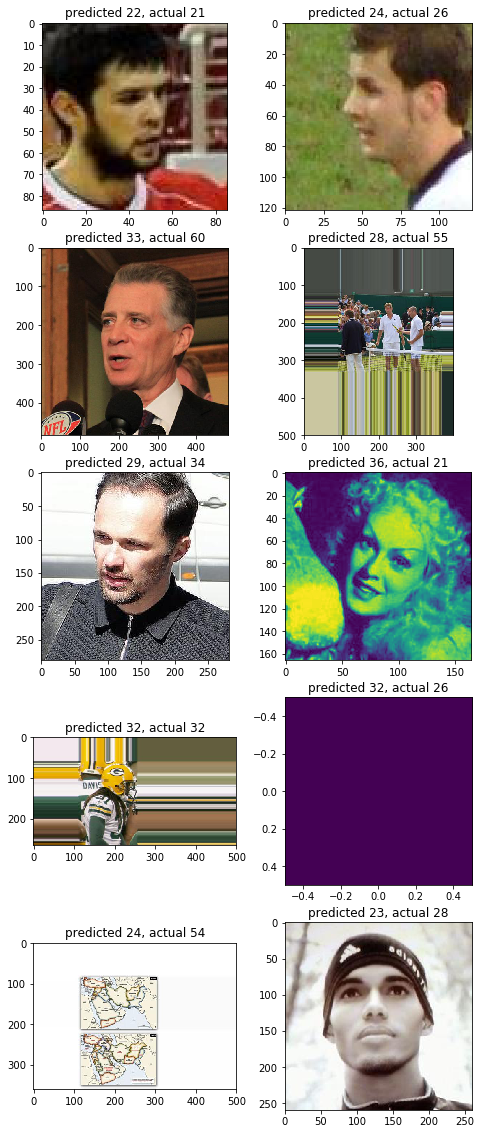

In [43]:
from skimage.io import imread
n_sample = 10
fig, axes = plt.subplots(5, 2, figsize= (2 * 4, 5 * 4))
axes = axes.ravel()
sample = np.random.randint(0, len(test_data), n_sample)
sample_files = np.array(test_files)[sample]
sample_ages = [test_data[s][1] for s in sample]
sample_predictions = predictions[sample]
images = [imread(f) for f in sample_files]

for i in range(n_sample):
    title = "predicted %i, actual %i" % (sample_predictions[i]*100, sample_ages[i]*100)
    axes[i].imshow(images[i])
    axes[i].set_title(title)

In [27]:
def predict(image):
    x = preprocess(image)
    X = Variable(torch.unsqueeze(x, 0)).cuda()
    if X.size()[0] == 1:
        X = torch.cat([X, X, X], dim=0)
    return model(X).data.cpu().numpy()[0][0]

7315  predicted:  0.391971  actual:  0.37


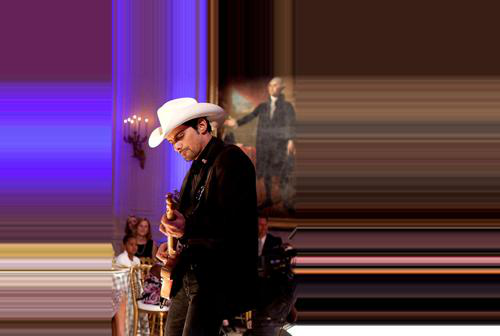

In [31]:
i = np.random.randint(0, len(test_data))
image = Image.open(test_files[i])
print(i, " predicted: ", predict(image), " actual: ", test_data[i][1])
image